# KAGGLE-LIKE CHALLENGE
On vous propose ici de tester tout ce que vous avez appris sur le machine learning supervisé, dans le but de faire un modèle de prédiction sur des données fournies, à la manière des compétitions Kaggle.

**Déroulement d'un challenge Kaggle**
- Kaggle vous envoie toujours deux datasets :
  - un fichier data_train.csv qui contient des données correspondant aux variables X, et au label Y à prédire. Utilisez ce fichier pour entraîner vos modèles comme d'habitude.
  - un fichier data_test.csv, qui contient les données X au même format que dans data_train.csv, mais cette fois les labels sont cachés. Votre but est de faire des prédictions sur ces données et de renvoyer ces prédictions à Kaggle, pour qu'ils évaluent votre modèle de manière indépendante
- Kaggle compare vos prédictions aux vrais labels et propose un leaderboard (équipes classées en fonction de leur score)
- Kaggle vous annonce à l'avance quelle métrique va être utilisée pour évaluer les modèles : veillez à utiliser la même métrique pour évaluer les performances de vos modèles

**Prédiction de conversion**

Ici, on vous propose d'essayer de créer le meilleur modèle pour prédire des conversions en fonction de différentes variables explicatives. Vos modèles seront évalués à l'aide du f1-score.

*Inspirez-vous du template ci-dessous pour la lecture des fichiers, la structure à suivre, et l'écriture des prédictions finales.*

In [106]:
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Read file with labels

In [107]:
df = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', df.shape)

Set with labels (our train+test) : (284580, 6)


In [108]:
#df['age_page'] = df['age'] * df['total_pages_visited']

# Explore dataset

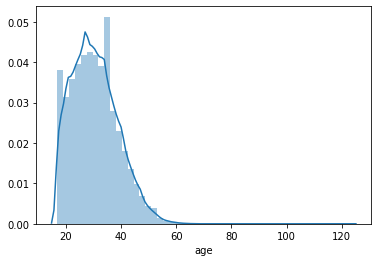

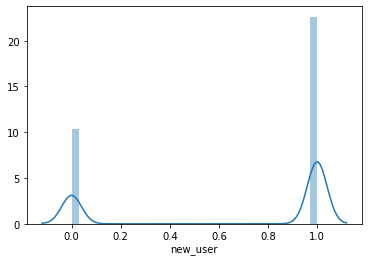

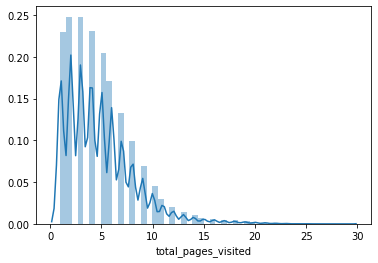

In [109]:
for c in ["age", "new_user", "total_pages_visited"]:
    sns.distplot(df[c])
    plt.show()

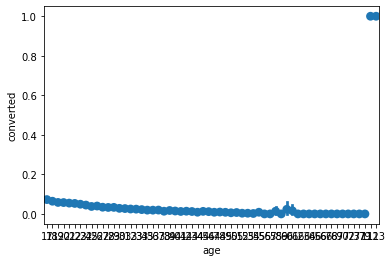

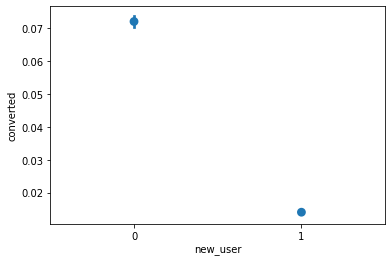

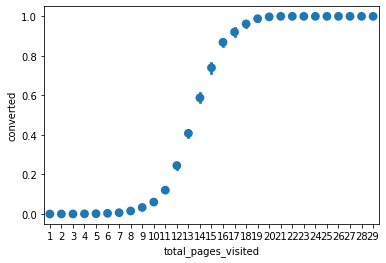

In [110]:
for f in ["age", "new_user", "total_pages_visited"] :
    sns.pointplot(df[f], df['converted'], join=False)
    plt.show()

# Make your model (as always)

## Choose variables to use in the model, and create train and test sets

In [111]:
features_list_n = ["age"]

for f in features_list_n:
    print('------------')
    print('Looking for outliers in ', f)
    mu = df[f].mean()
    sigma = df[f].std()
    min_val = mu - 3*sigma
    max_val = mu + 3*sigma
    is_outlier = (df[f]<min_val) | (df[f]>max_val)
    
    if is_outlier.any():
        print('Found {} outliers'.format(is_outlier.sum()))
        print('Dropping outliers...')
        df = df.loc[~is_outlier,:]
        print('Done.')
        print('Number of lines remaining in dataset : ', df.shape[0])
    
    print()

------------
Looking for outliers in  age
Found 1017 outliers
Dropping outliers...
Done.
Number of lines remaining in dataset :  283563



In [112]:
# On ajoute cette variable au dataset
df.loc[:,'tpv_sig'] = df['total_pages_visited'].apply(lambda x : 1/(1+np.exp(-x)))
display(df.head())

,country,age,new_user,source,total_pages_visited,converted,tpv_sig
0,China,22,1,Direct,2,0,0.880797
1,UK,21,1,Ads,3,0,0.952574
2,Germany,20,0,Seo,14,1,0.999999
3,US,23,1,Seo,3,0,0.952574
4,US,28,1,Direct,3,0,0.952574


In [113]:
df.describe(include="all")

,country,age,new_user,source,total_pages_visited,converted,tpv_sig
count,283563,283563.000000,283563.000000,283563,283563.000000,283563.000000,283563.000000
unique,4,NaN,NaN,3,NaN,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN,NaN
freq,159528,NaN,NaN,138990,NaN,NaN,NaN
mean,NaN,30.463262,0.685442,NaN,4.873996,0.032349,0.938804
std,NaN,8.104432,0.464340,NaN,3.343592,0.176926,0.088889
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000,0.731059
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000,0.880797
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000,0.982014
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000,0.999089


In [114]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ["country", "age", "new_user", "source", "total_pages_visited", 'tpv_sig']
target_variable = "converted"

X = df.loc[:,features_list]
Y = df.loc[:,target_variable]

print("...Done.")
print()

print('y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  age  new_user  source  total_pages_visited   tpv_sig
0    China   22         1  Direct                    2  0.880797
1       UK   21         1     Ads                    3  0.952574
2  Germany   20         0     Seo                   14  0.999999
3       US   23         1     Seo                    3  0.952574
4       US   28         1  Direct                    3  0.952574


In [115]:
# Search categorical features and numeric features

idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
  if ('float' in str(t)) or ('int' in str(t)) :
    numeric_features.append(i)
    numeric_indices.append(idx)
  else :
    categorical_features.append(i)
    categorical_indices.append(idx)

  idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['age', 'new_user', 'total_pages_visited', 'tpv_sig']  at positions  [1, 2, 4, 5]
Found categorical features  ['country', 'source']  at positions  [0, 3]


In [116]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [117]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[['China' 46 1 'Seo' 2 0.8807970779778823]
 ['US' 29 1 'Direct' 6 0.9975273768433653]
 ['China' 39 1 'Direct' 6 0.9975273768433653]
 ['China' 34 0 'Ads' 6 0.9975273768433653]
 ['US' 23 0 'Ads' 20 0.9999999979388463]]
[['China' 23 1 'Ads' 4 0.9820137900379085]
 ['China' 30 0 'Direct' 13 0.999997739675702]]

[0 0 0 0 1]
[0 0]


## Training pipeline

In [118]:
# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print()
print(X_train[0:5,:])
print()
print(X_test[0:5,:])

# Normalization
numeric_transformer = StandardScaler()

# OneHotEncoder
categorical_transformer = OneHotEncoder(drop='first')

featureencoder = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)        
        ]
    )

X_train = featureencoder.fit_transform(X_train)
X_test = featureencoder.transform(X_test)
print("...Done")
print(X_train[0:5,:])
print(X_test[0:5])

Encoding categorical features and standardizing numerical features...

[['China' 46 1 'Seo' 2 0.8807970779778823]
 ['US' 29 1 'Direct' 6 0.9975273768433653]
 ['China' 39 1 'Direct' 6 0.9975273768433653]
 ['China' 34 0 'Ads' 6 0.9975273768433653]
 ['US' 23 0 'Ads' 20 0.9999999979388463]]

[['China' 23 1 'Ads' 4 0.9820137900379085]
 ['China' 30 0 'Direct' 13 0.999997739675702]
 ['US' 32 1 'Seo' 1 0.7310585786300049]
 ['US' 27 1 'Ads' 3 0.9525741268224334]
 ['UK' 25 1 'Seo' 5 0.9933071490757153]]
...Done
[[ 1.91207418  0.67836596 -0.85951933 -0.65182373  0.          0.
   0.          0.          1.        ]
 [-0.18468574  0.67836596  0.33660037  0.66048794  0.          0.
   1.          1.          0.        ]
 [ 1.04870245  0.67836596  0.33660037  0.66048794  0.          0.
   0.          1.          0.        ]
 [ 0.43200836 -1.47413057  0.33660037  0.66048794  0.          0.
   0.          0.          0.        ]
 [-0.92471865 -1.47413057  4.52301931  0.68828577  0.          0.
   1.  

In [119]:
# Train model
print("Train model...")
# classifier = LogisticRegressionCV(Cs= 18, n_jobs= -1, verbose=1, cv=10)
classifier = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=1, warm_start=False)
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
...Done.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.1s finished


In [120]:
# Train model
print("Train model...")
classifier = LogisticRegressionCV(Cs= 10, penalty='l1', solver='liblinear', n_jobs= -1, verbose=1, cv=10)

classifier.fit(X_train, Y_train)
print("...Done.")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Train model...
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.4min finished
...Done.


## Test pipeline

In [121]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [122]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 1 0 0]



## Performance assessment

In [123]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.763645770457877
f1-score on test set :  0.7629449838187703


In [124]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[191325    748]
 [  1993   4428]]

Confusion matrix on test set : 
[[82011   306]
 [  866  1886]]



In [125]:
# print classification report
print("Classification Report on Test set:\n\n", classification_report(Y_test, Y_test_pred))

Classification Report on Test set:

               precision    recall  f1-score   support

           0       0.99      1.00      0.99     82317
           1       0.86      0.69      0.76      2752

    accuracy                           0.99     85069
   macro avg       0.92      0.84      0.88     85069
weighted avg       0.99      0.99      0.99     85069



# Train best classifier on all data and use it to make predictions on X_without_labels

In [126]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.6min finished


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=1)

In [127]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

Prediction set (without labels) : (31620, 5)


In [128]:
features_list_n = ["age"]

for f in features_list_n:
    print('------------')
    print('Looking for outliers in ', f)
    mu = data_without_labels[f].mean()
    sigma = data_without_labels[f].std()
    min_val = mu - 3*sigma
    max_val = mu + 3*sigma
    is_outlier = (data_without_labels[f]<min_val) | (data_without_labels[f]>max_val)
    
    if is_outlier.any():
        print('Found {} outliers'.format(is_outlier.sum()))
        print('Dropping outliers...')
        data_without_labels = data_without_labels.loc[~is_outlier,:]
        print('Done.')
        print('Number of lines remaining in dataset : ', data_without_labels.shape[0])
    
    print()

------------
Looking for outliers in  age
Found 139 outliers
Dropping outliers...
Done.
Number of lines remaining in dataset :  31481



In [129]:
# On ajoute cette variable au dataset
data_without_labels.loc[:,'tpv_sig'] = data_without_labels['total_pages_visited'].apply(lambda x : 1/(1+np.exp(-x)))
display(df.head())

,country,age,new_user,source,total_pages_visited,converted,tpv_sig
0,China,22,1,Direct,2,0,0.880797
1,UK,21,1,Ads,3,0,0.952574
2,Germany,20,0,Seo,14,1,0.999999
3,US,23,1,Seo,3,0,0.952574
4,US,28,1,Direct,3,0,0.952574


In [130]:
#data_without_labels['age_page'] = data_without_labels['age'] * data_without_labels['total_pages_visited']
# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ["country", "age", "new_user", "source", "total_pages_visited", 'tpv_sig']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Convert pandas DataFrames to numpy arrays...
...Done
[['UK' 28 0 'Seo' 16 0.9999998874648379]
 ['UK' 22 1 'Direct' 5 0.9933071490757153]
 ['China' 32 1 'Seo' 1 0.7310585786300049]
 ['US' 32 1 'Ads' 6 0.9975273768433653]
 ['China' 25 0 'Seo' 3 0.9525741268224334]]


In [131]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.30802455 -1.47413057  3.32689962  0.68828453  0.          1.
   0.          0.          1.        ]
 [-1.04805747  0.67836596  0.03757044  0.61304306  0.          1.
   0.          1.          0.        ]
 [ 0.18533072  0.67836596 -1.15854926 -2.33522198  0.          0.
   0.          0.          1.        ]
 [ 0.18533072  0.67836596  0.33660037  0.66048794  0.          0.
   1.          0.          0.        ]
 [-0.67804101 -1.47413057 -0.56048941  0.15511208  0.          0.
   0.          0.          1.        ]]


In [132]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_LORENZO-Model7.csv', index=False)
